# Compare models trained on mixed class data

This compares several different models trained on **mixed** *longliner*,
*trawler* and *purse seiner* data.

**NOTE: this was somewhat unstable. Running multiple times yielded significantly different results, 
  depending the data split.  I set seeds everywhere and now the output is stable. However, this tells 
  me that we want more data!**

In [1]:
%matplotlib inline
import numpy as np
from vessel_scoring import data
from vessel_scoring.evaluate_model import evaluate_model, train_model, compare_models
from IPython.core.display import display, HTML

In [2]:
x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel('datasets/slow-transits_scored.measures.npz',
                                                                     even_split=False)

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


In [3]:
set(x_tran['mmsi'])

{367512180.0, 367512510.0, 367534310.0, 367721000.0}

In [4]:
_, xtrain_trawl, xcross_trawl, xtest_trawl = data.load_dataset_by_vessel('datasets/kristina_trawl.measures.npz')
_, xtrain_lline, xcross_lline, xtest_lline = data.load_dataset_by_vessel('datasets/kristina_longliner.measures.npz')
_, xtrain_pseine, xcross_pseine, xtest_pseine = data.load_dataset_by_vessel('datasets/kristina_ps.measures.npz')

In [5]:
def clone_subset(x, dtype):
    """copy only the portions of x in dtype to a new array"""
    new = np.zeros(x.shape, dtype=dtype)
    for name in dtype.names:
        new[name] = x[name]
    return new
        
# We need to make the fields in the tran data match that of the other 
# to concatenate
xtrain_tran = clone_subset(xtrain_tran, xtrain_lline.dtype)
xcross_tran = clone_subset(xcross_tran, xtrain_lline.dtype)
xtest_tran = clone_subset(xtest_tran, xtrain_lline.dtype)

In [6]:
TRANSIT_WEIGHT = 10

xtrain = np.concatenate([xtrain_trawl, xtrain_lline, xtrain_pseine] + [xtrain_tran] * TRANSIT_WEIGHT)
xcross = np.concatenate([xcross_trawl, xcross_lline, xcross_pseine] + [xcross_tran] * TRANSIT_WEIGHT)

train = np.concatenate([xtrain, xcross])

xtest = np.concatenate([xtest_trawl, xtest_lline, xtest_pseine, xtest_tran])

In [7]:
from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.random_forest_model import RandomForestModel
from vessel_scoring.logistic_model import LogisticModel

untrained_models = [
    ('Logistic', LogisticModel(windows=[43200], order=6)),
    ('Logistic opt MSE', LogisticModel(windows=[43200], order=4, cross=3)),
#     ('Logistic (MW)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400], order=6)),
#     ('Logistic (MW/cross3)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400], order=6, cross=2)),
    ('Random Forest', RandomForestModel(windows=[43200])),
#     ('Random Forest (MW)', RandomForestModel(windows=[1800, 3600, 10800, 21600, 43200, 86400])),
#     ('Legacy', LegacyHeuristicModel(window=3600)),
#     ("Legacy (3 Hour)", LegacyHeuristicModel(window=10800)),
#     ("Legacy (12 Hour)", LegacyHeuristicModel(window=43200)),
#     ("Legacy (24 Hour)", LegacyHeuristicModel(window=86400)),  
]

trained_models = [(name, train_model(mdl, train)) for (name, mdl) in untrained_models]

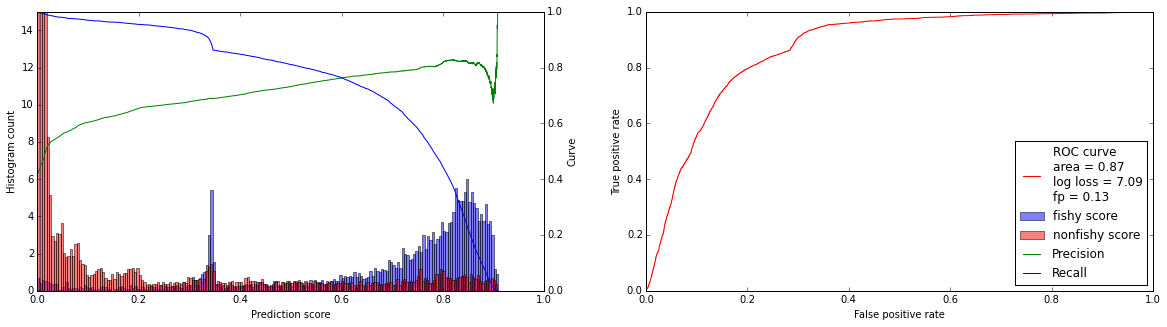

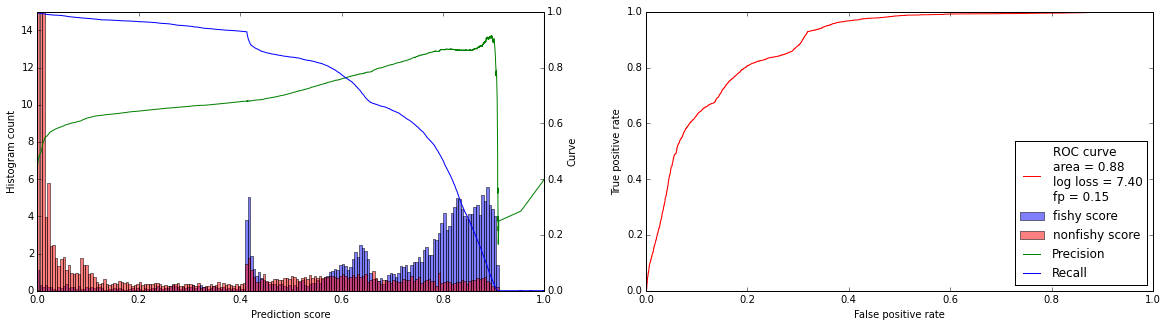

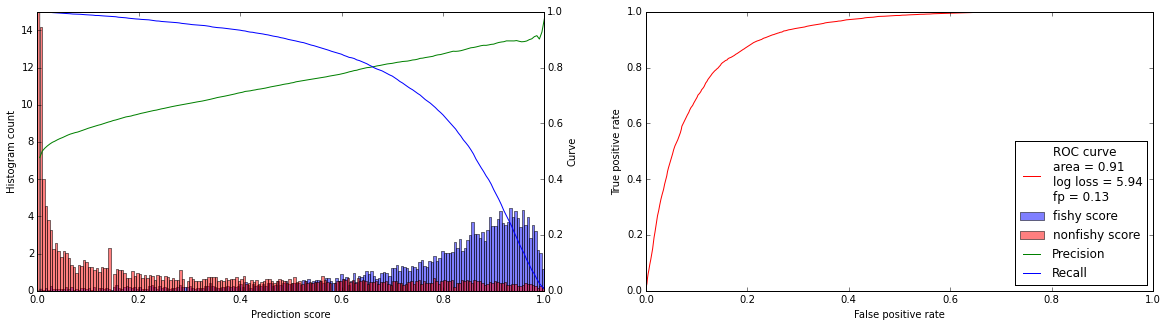

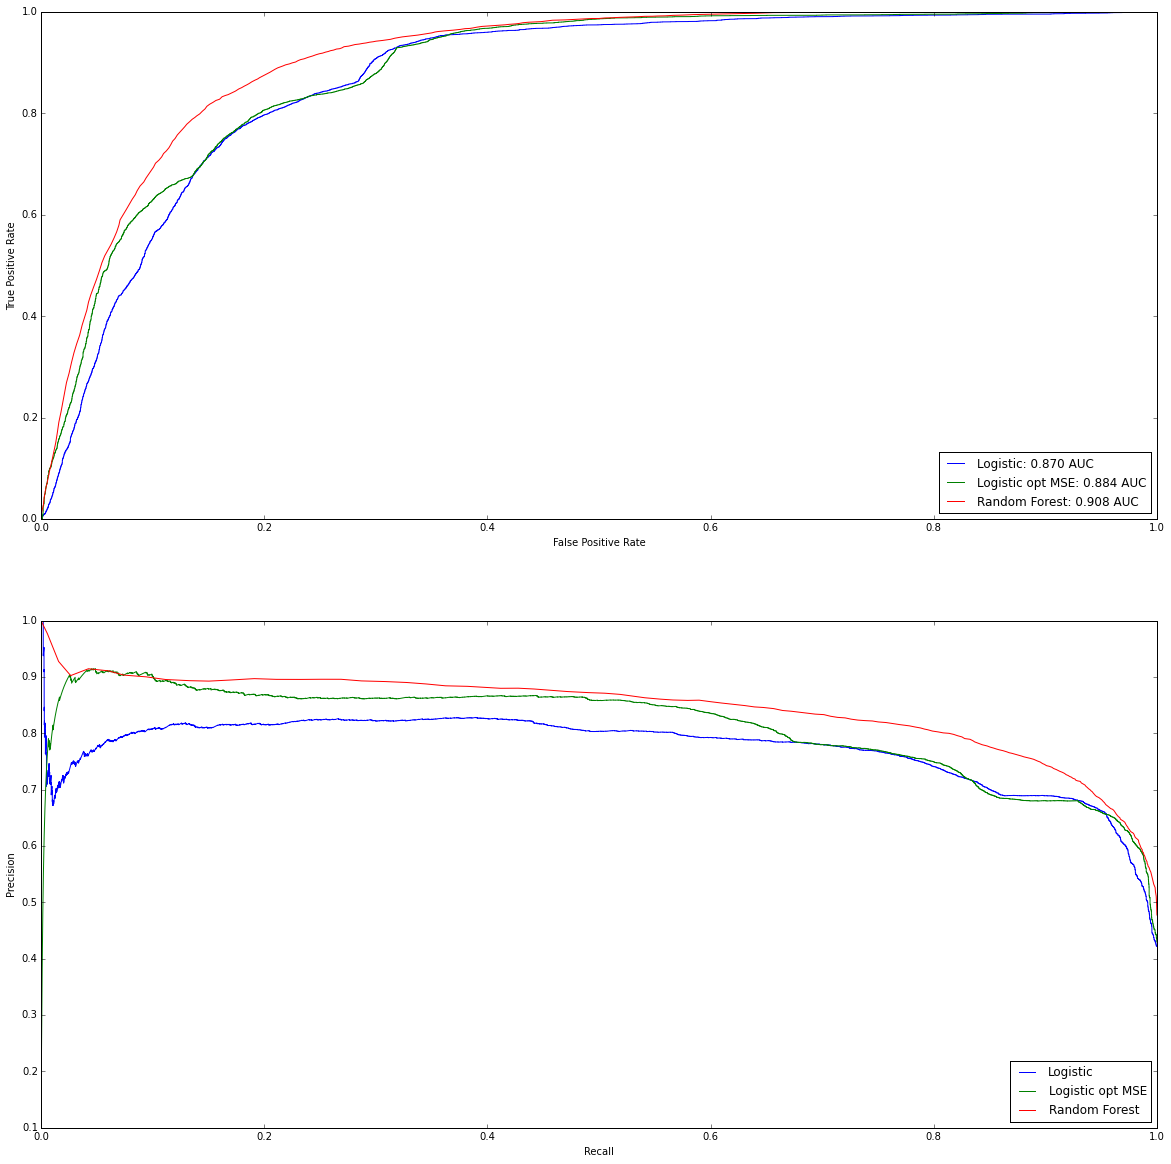

In [8]:
display(HTML("<h1>Overall Comparison</h1>"))
for name, mdl in trained_models:
    evaluate_model(mdl, xtest, name=name)

display(HTML("<h1>Overall comparison</h1>"))
compare_models(trained_models, xtest)

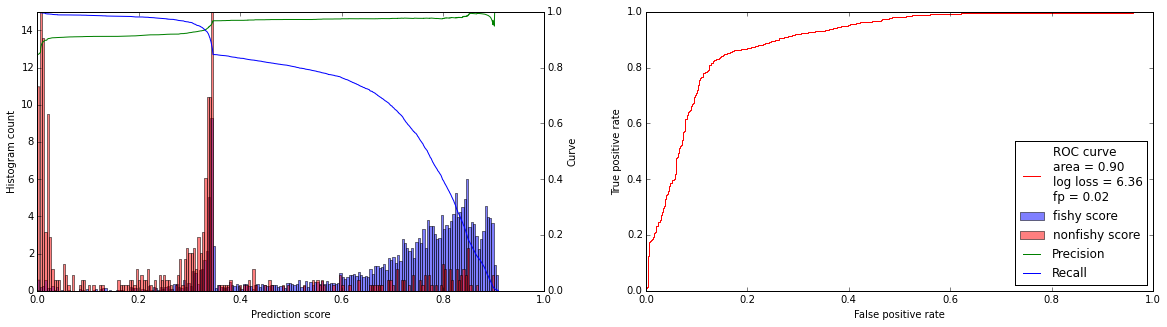

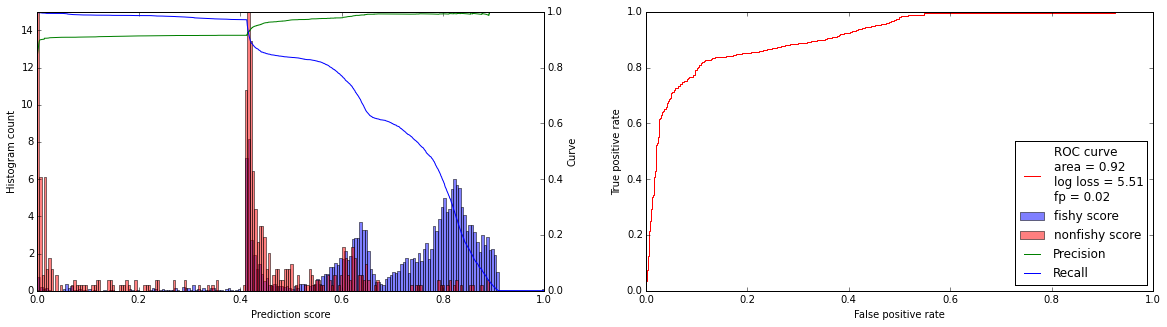

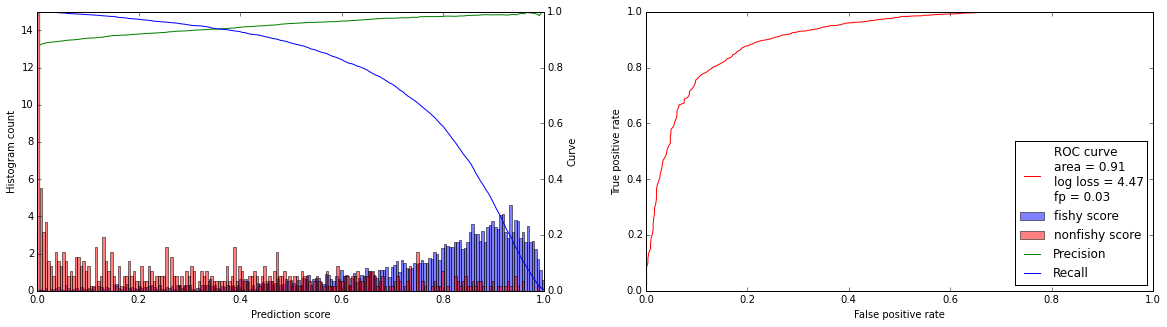

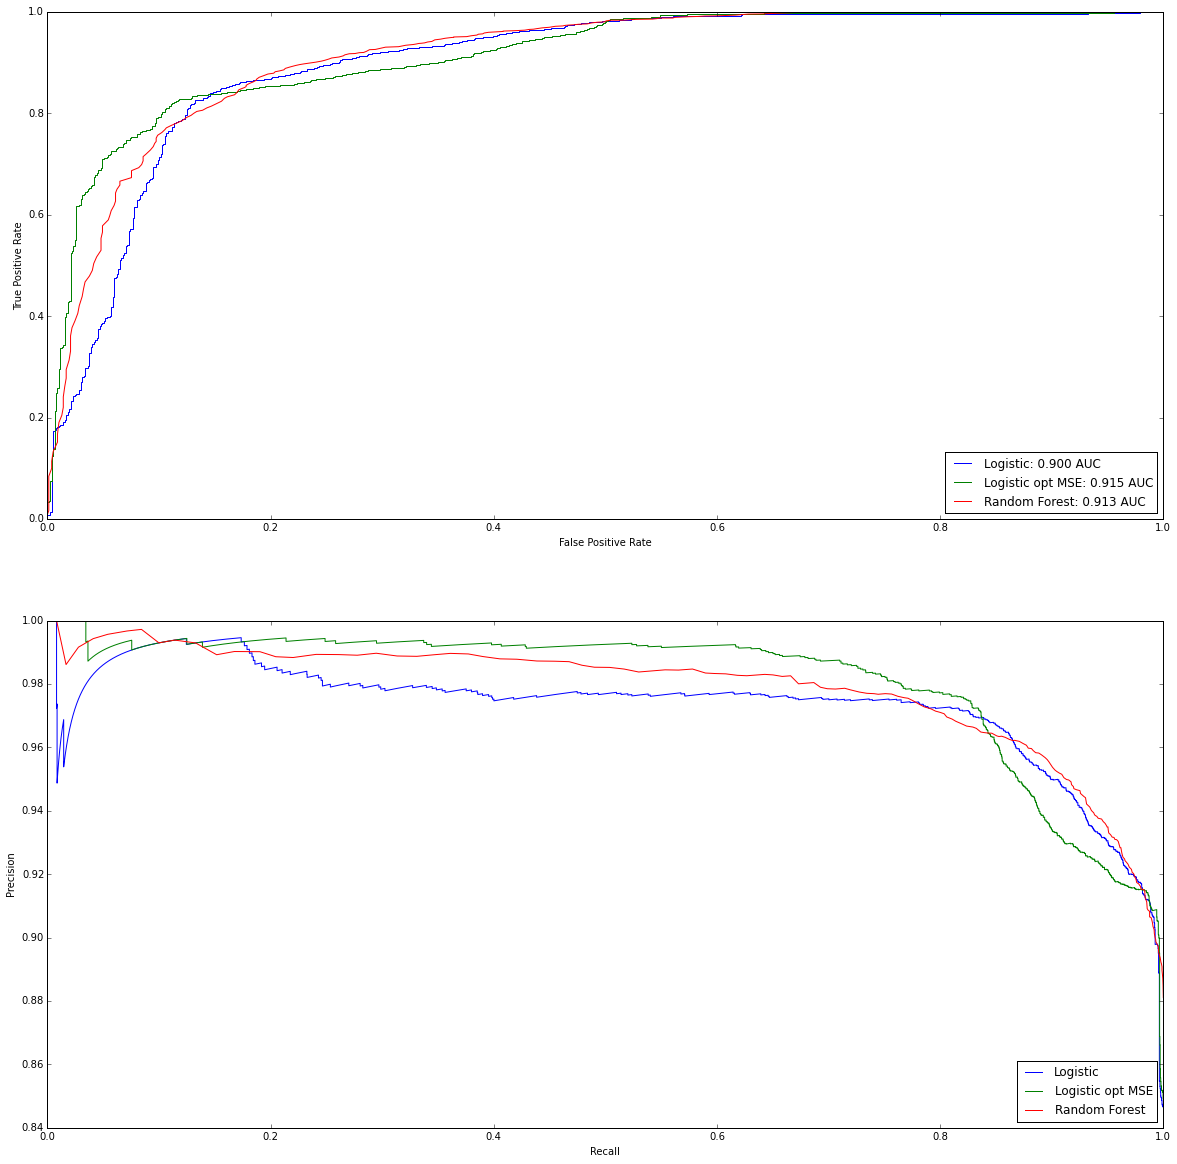

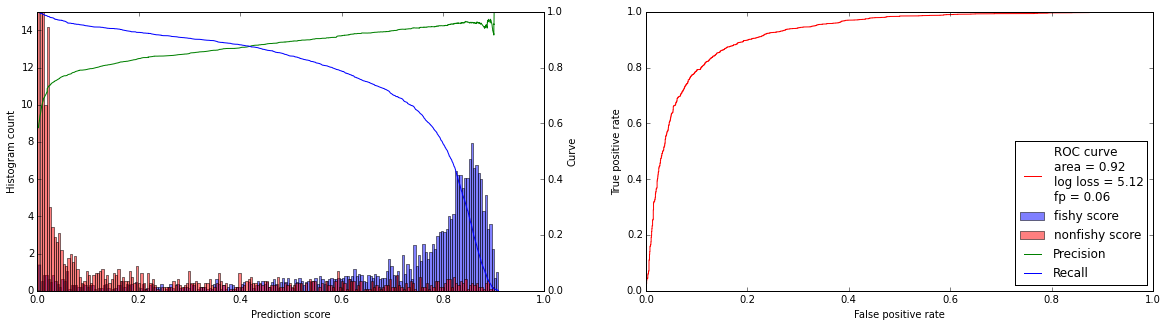

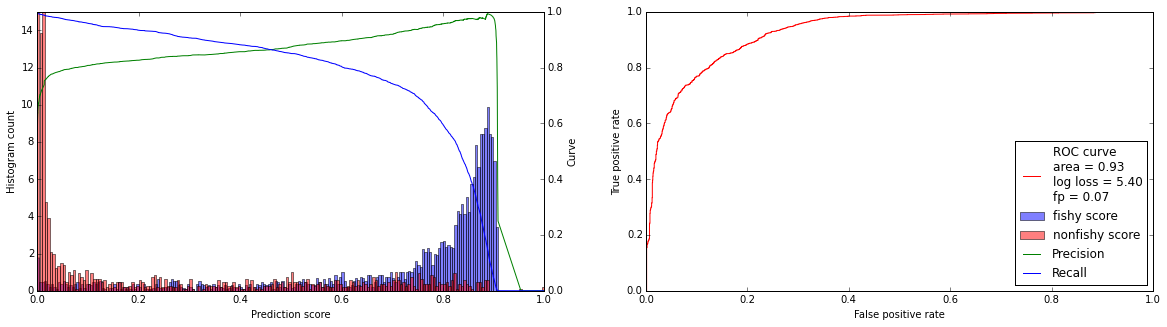

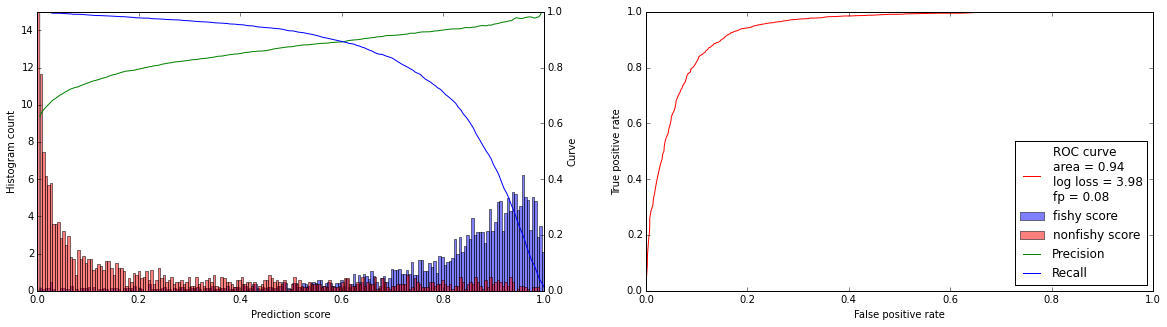

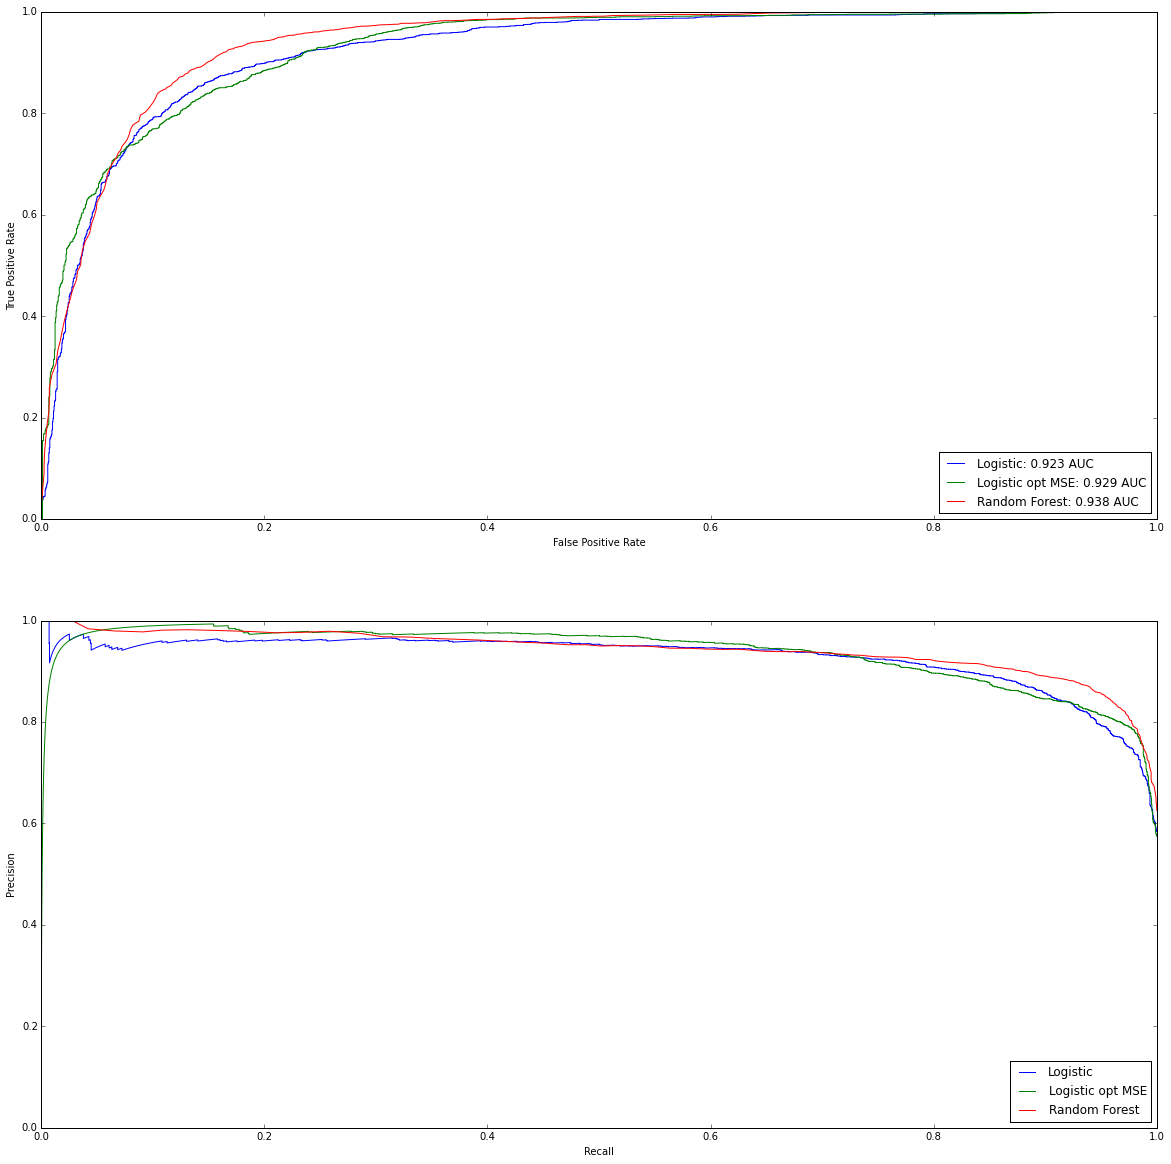

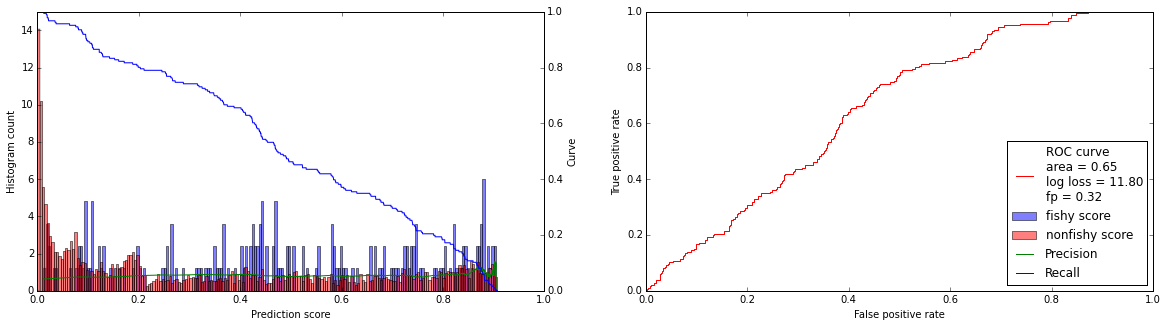

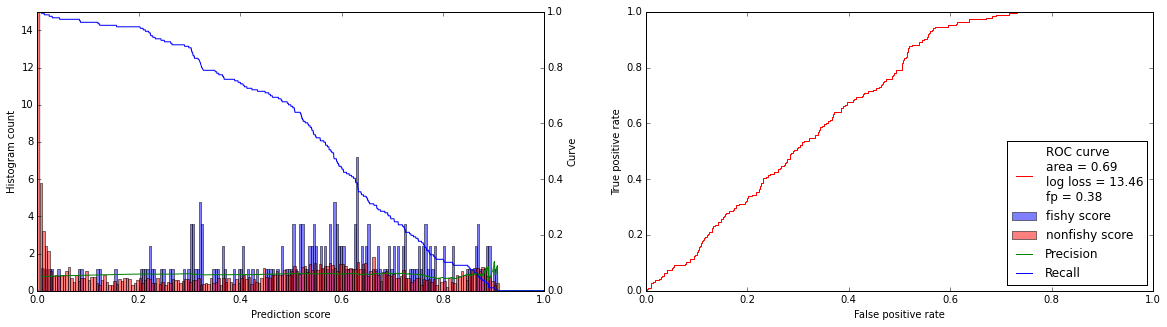

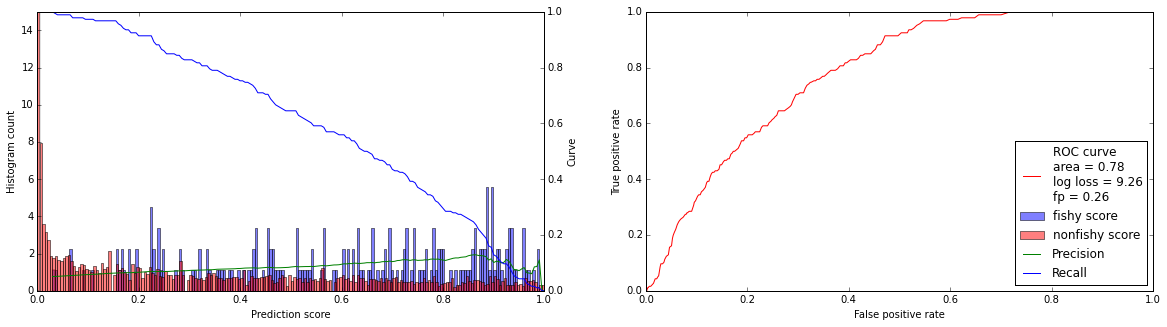

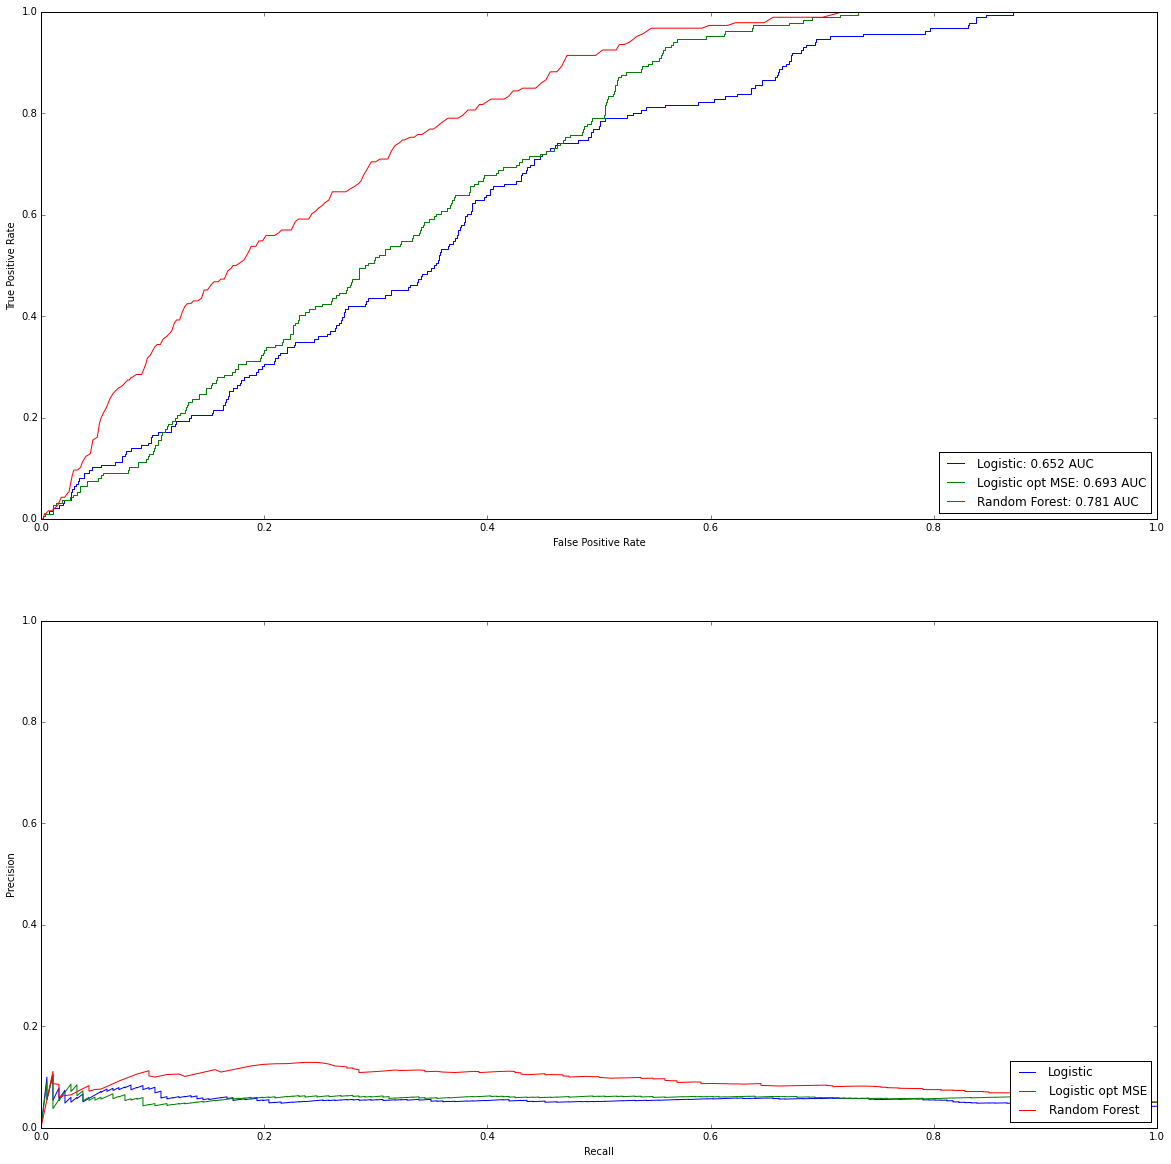

In [9]:
for vessel_class, xtest_class in  [("longliner", xtest_lline), 
                                   ("trawler", xtest_trawl), 
                                   ("purse seine", xtest_pseine)]:
    display(HTML("<h1>Comparison for {0}</h1>".format(vessel_class)))
    for name, mdl in trained_models:
        evaluate_model(mdl, xtest_class, name=name)
    display(HTML("<h1>Comparison for {0}</h1>".format(vessel_class)))
    compare_models(trained_models, xtest_class)

# How does this model do on the slow transit tracks?

In [10]:
for name, mdl in trained_models:
    p = mdl.predict_proba(xtest_tran)[:,1]
    print name, p.mean(), (p > 0.5).mean()

Logistic 0.0917682900671 0.0761398849048
Logistic opt MSE 0.0878392899986 0.0761398849048
Random Forest 0.192321823816 0.179725542275


## What about the new transit tracks?

In [11]:
from vessel_scoring import data
x_tran2 = np.load('datasets/new_transits.measures.npz')['x']

# We are somehow getting an extra, 0 MMSI. Why?
# Results are totally bogus
x_tran2 = x_tran2[x_tran2['mmsi'] != 0]

print "Transit tracks for", sorted(set(x_tran2['mmsi']))
assert not (set(x_tran2['mmsi']) & set(x_tran['mmsi'])), "overlap between old and new transit sets"
print
for name, mdl in trained_models:
    p = mdl.predict_proba(x_tran2)[:,1]
    print name, p.mean(), (p > 0.5).mean()

Transit tracks for [367512170.0, 412420562.0, 412420979.0, 412420992.0]

Logistic 0.0424441928908 0.0275235271368
Logistic opt MSE 0.0385831922982 0.0282325641356
Random Forest 0.0959652571871 0.0583344076318


## Where are the false positives?

The important thing is that the false positives are not evenly spaced out, so they shouldn't
show up as track like.

FP rate for MMSI 367512170 is: 0.0240619902121
FP rate for MMSI 412420562 is: 0.0645048814505
FP rate for MMSI 412420979 is: 0.0236575291025
FP rate for MMSI 412420992 is: 0.00372516556291


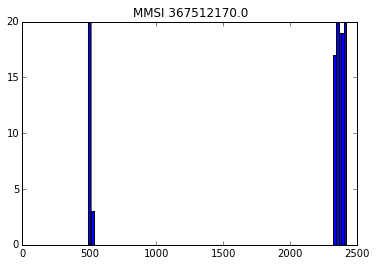

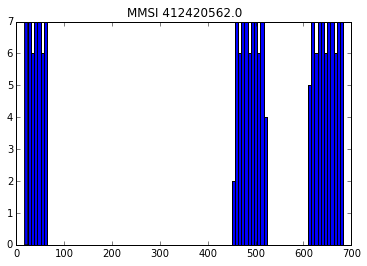

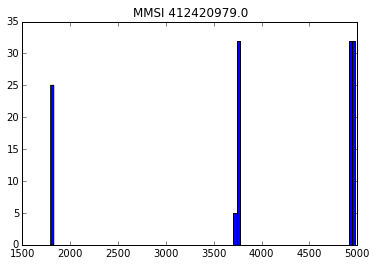

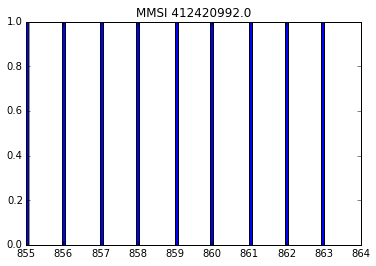

In [12]:
import matplotlib.pyplot as plt
mmsi = sorted(set(x_tran2['mmsi']))

name, mdl = trained_models[1]

for m in mmsi:
    subset = x_tran2[x_tran2['mmsi'] == m]
    n = len(subset)
    locs = np.arange(n)[mdl.predict_proba(subset)[:,1] > 0.5]
    print "FP rate for MMSI", int(m), "is:", len(locs) / float(n)
    plt.figure()
    plt.title("MMSI {0}".format(m))
    plt.hist(locs, bins=100)

## Verify that we get same results when training using saved models

When loading from saved models we still get the same result

In [13]:
from vessel_scoring.logistic_model import LogisticScorer
from glob import glob
import json
paths = glob("vessel_scoring/models/*.json")

print "Transit tracks for", sorted(set(x_tran2['mmsi']))
assert not (set(x_tran2['mmsi']) & set(x_tran['mmsi'])), "overlap between old and new transit sets"
print
for pth in paths:
    with open(pth) as f:
        args = json.load(f)['args']['args']
    mdl = LogisticScorer(**args)
    p = mdl.predict_proba(x_tran2)[:,1]
    print pth, p.mean(), (p > 0.5).mean()

Transit tracks for [367512170.0, 412420562.0, 412420979.0, 412420992.0]



TypeError: __init__() takes exactly 6 arguments (1 given)

## Results when not training with transit data.

    Logistic 0.838618506196 0.984949092519
    Logistic opt MSE 0.826260344662 0.986277113767
    Random Forest 0.718120849934 0.885790172643
    Legacy 0.623862134036 0.773351040283
    Legacy (12 Hour) 0.66843170167 0.912793271359
    
**If we don't train on these slow transit tracks, results are pretty awful**

# Dumping the model and using LogisticScorer

LogisticScorer is a simple reimplementation of the prediciton part of 
the logistic predictor. This way we can dump out the parameters from 
the model and then use it in the pipeline where we potentially can
optimize it for that particular application.

In [ ]:
from vessel_scoring.logistic_model import LogisticScorer

scorer = LogisticScorer(**trained_models[1][1].dump_dict())

print scorer.fishing_score(xtest).max()
print scorer.predict_proba(xtest)[:,1].max()
print trained_models[1][1].predict_proba(xtest)[:,1].max()

evaluate_model(scorer, xtest)

In [ ]:
# Verify that we can also load LogisticModels from dumped LogisticModels
# Had to abuse sklearn interface a bit for this to work
import imp, vessel_scoring.logistic_model
imp.reload(vessel_scoring.logistic_model)


from vessel_scoring.logistic_model import LogisticModel


model = LogisticModel(**trained_models[1][1].dump_dict())

print model.predict_proba(xtest)[:,1].max()
print trained_models[1][1].predict_proba(xtest)[:,1].max()

evaluate_model(model, xtest)

In [ ]:
import json

trained_models[1][1].dump_dict()